In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-19T22:34:52.670056+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn import preprocessing

from typing import Tuple

In [4]:
from xgboost import __version__ as xgb_version
from sklearn import __version__ as sklearn_version

print(f'xgb_version: {xgb_version}')
print(f'sklearn_version: {sklearn_version}')

xgb_version: 1.6.1
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

xgboost: 1.6.1
numpy  : 1.20.3
sklearn: 0.24.2
pandas : 0.25.3



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 20
NAME = f'{NTRY}_xgb_pca64_sber_lags_parse_bord_nose_full'

In [9]:
#CTR_UKR = 6.096
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [10]:
df_train  = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

#with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
#    cat_cols = pkl.load(pickle_file)
    
#with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
#    num_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [11]:
x_train.shape, x_val.shape, df_test.shape, #len(cat_cols), len(num_cols)

((5584, 292), (1397, 292), (3000, 289))

отделяем метки от данных

In [12]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5584, 289), (1397, 289), (5584, 3), (1397, 3))

In [13]:
#cat_cols + num_cols

In [14]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [15]:
num_cols.extend(['hour', 'mounth', 'dow',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 'two_articles',
                 #'spec_event_1',
                ])
#cat_cols.extend(['dow'])

In [16]:
def plot_importance(inp_model, imp_number = 30, imp_type = 'weight'):
    feature_important = inp_model.get_booster().get_score(importance_type=imp_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(imp_number, columns="score").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [17]:
cv_ntrees = 100

In [18]:
#def r2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
def r2(y_pred: np.ndarray, y_true: xgb.DMatrix) -> Tuple[str, float]:
    
    #preds = np.array(y_pred[0])
    #print(type(y_true))
    #print(type(y_pred)) # np.array
    
    return 'r2', r2_score(y_true.get_label(), y_pred)

## views

In [19]:
#xgb.set_config(verbosity=0)
#xgb_spec = ['day', 'mounth', 'authors_int', 'category_int']

In [20]:
xgb_params_views = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(df_train[num_cols], label=df_train[['views']])
#dtrain = xgb.DMatrix(df_train[xgb_spec], label=df_train[['views']])

In [21]:
%%time
score = xgb.cv(xgb_params_views, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )

Wall time: 24.4 s


In [22]:
score.tail(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,4003.468111,190.336500,43792.502490,11923.606274,0.995444,0.001213,0.444008,0.059924
96,3977.762253,190.520340,43792.830754,11924.592391,0.995499,0.001217,0.444004,0.059923
97,3943.788627,193.005355,43795.647842,11923.899580,0.995576,0.001195,0.443935,0.059818
98,3902.858186,207.614135,43808.044301,11933.215047,0.995662,0.001203,0.443646,0.059899
99,3864.380765,197.481640,43811.102208,11932.953479,0.995750,0.001160,0.443575,0.059773


In [23]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
99,3864.380765,197.48164,43811.102208,11932.953479,0.99575,0.00116,0.443575,0.059773


In [24]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
18,13632.72718,559.933897,43588.009905,12205.524327,0.948294,0.006664,0.450216,0.066209


In [25]:
xgb_model_views = XGBRegressor(#n_estimators=1000, 
                               #max_depth=7, 
                               #eta=0.1, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_views.fit(df_train[num_cols], df_train['views'], #x_train[num_cols], y_train['views'], 
                    #early_stopping_rounds=5,
                    #eval_set=[(x_val[num_cols], y_val['views'])], 
                    verbose=False
                   )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, reg_lambda=1, ...)

In [26]:
# Get predictions and metrics
preds_train_views = xgb_model_views.predict(x_train[num_cols])
preds_val_views   = xgb_model_views.predict(x_val[num_cols])

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.9941534129673786, 0.9922541681912243)

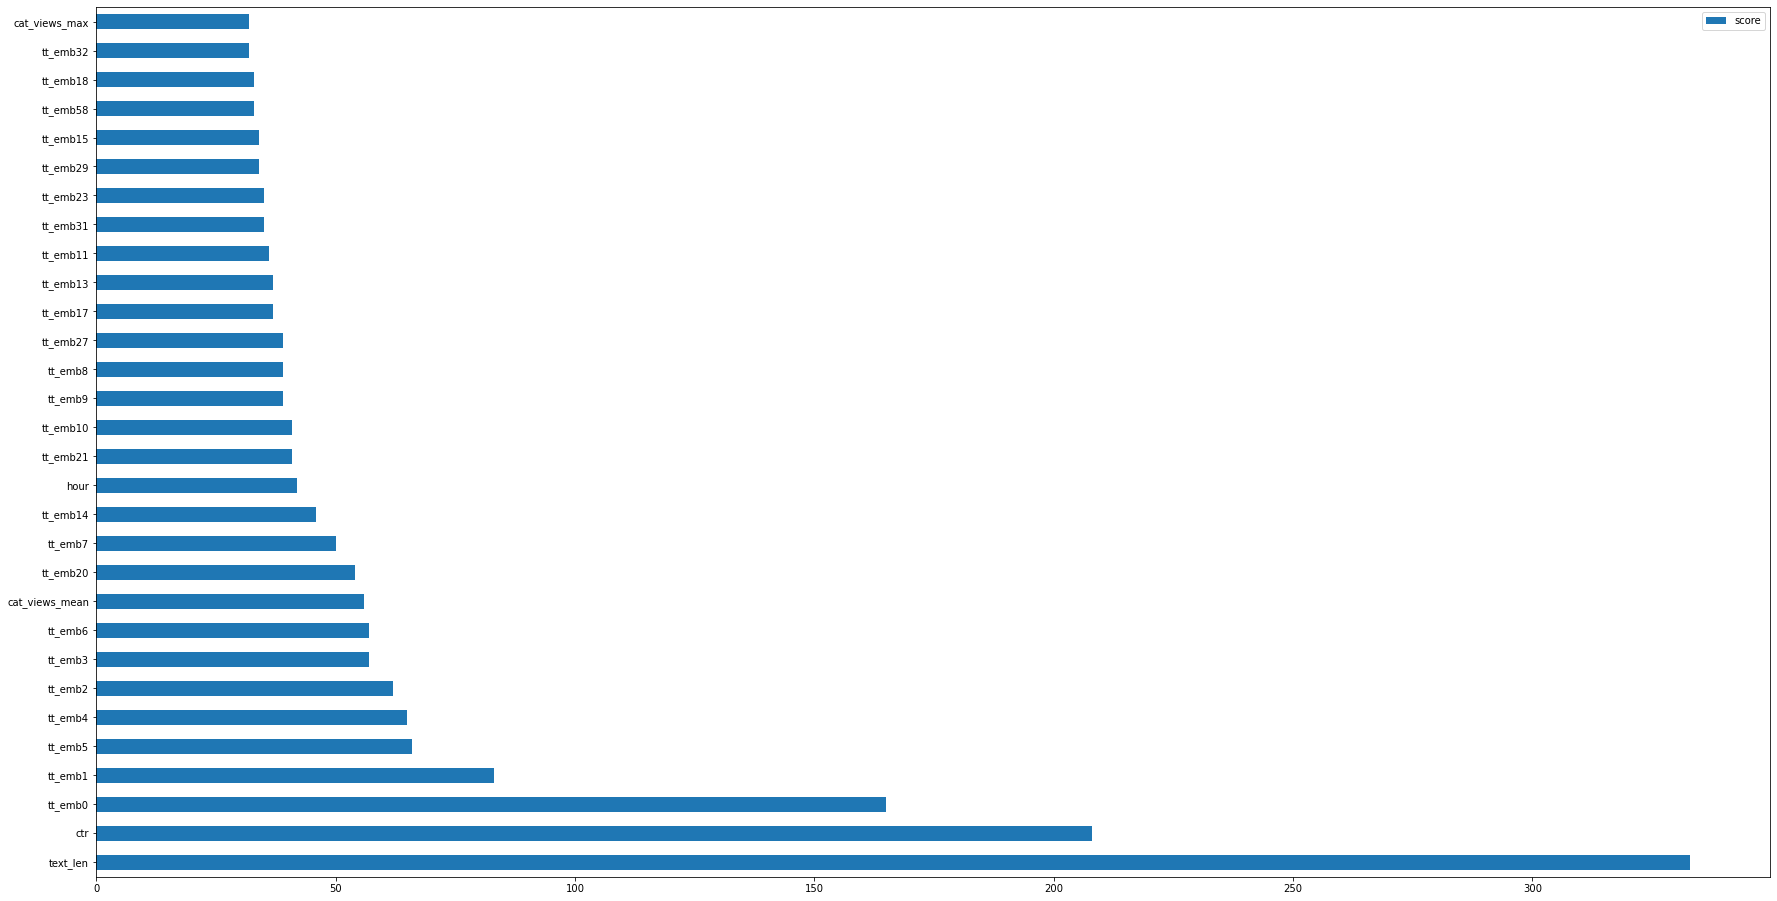

In [27]:
plot_importance(xgb_model_views, 30, 'weight')

## depth

In [28]:
xgb_params_depth = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(df_train[num_cols], label=df_train[['depth']])

In [29]:
%%time
score = xgb.cv(xgb_params_depth, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
score.tail()

Wall time: 24.1 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,0.005803,0.000232,0.027294,0.001209,0.991163,0.000742,0.803869,0.017132
96,0.005731,0.000216,0.027290,0.001210,0.991383,0.000690,0.803927,0.017150
97,0.005669,0.000225,0.027297,0.001210,0.991567,0.000723,0.803823,0.017201
98,0.005597,0.000221,0.027292,0.001206,0.991779,0.000710,0.803904,0.017100
99,0.005531,0.000202,0.027289,0.001199,0.991973,0.000654,0.803941,0.017064


In [30]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
99,0.005531,0.000202,0.027289,0.001199,0.991973,0.000654,0.803941,0.017064


In [31]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
21,0.015871,0.000357,0.026821,0.0014,0.934001,0.002731,0.810728,0.017039


In [32]:
xgb_model_depth = XGBRegressor(#n_estimators=1000, 
                               #max_depth=7, 
                               #eta=0.1, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_depth.fit(df_train[num_cols], df_train['depth'], #x_train[num_cols], y_train['depth'], 
                    #early_stopping_rounds=5,
                    #eval_set=[(x_val[num_cols], y_val['depth'])], 
                    verbose=False
                   )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, reg_lambda=1, ...)

In [33]:
# Get predictions and metrics
preds_train_depth = xgb_model_depth.predict(x_train[num_cols])
preds_val_depth   = xgb_model_depth.predict(x_val[num_cols])

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.9861142381131932, 0.9859012764650775)

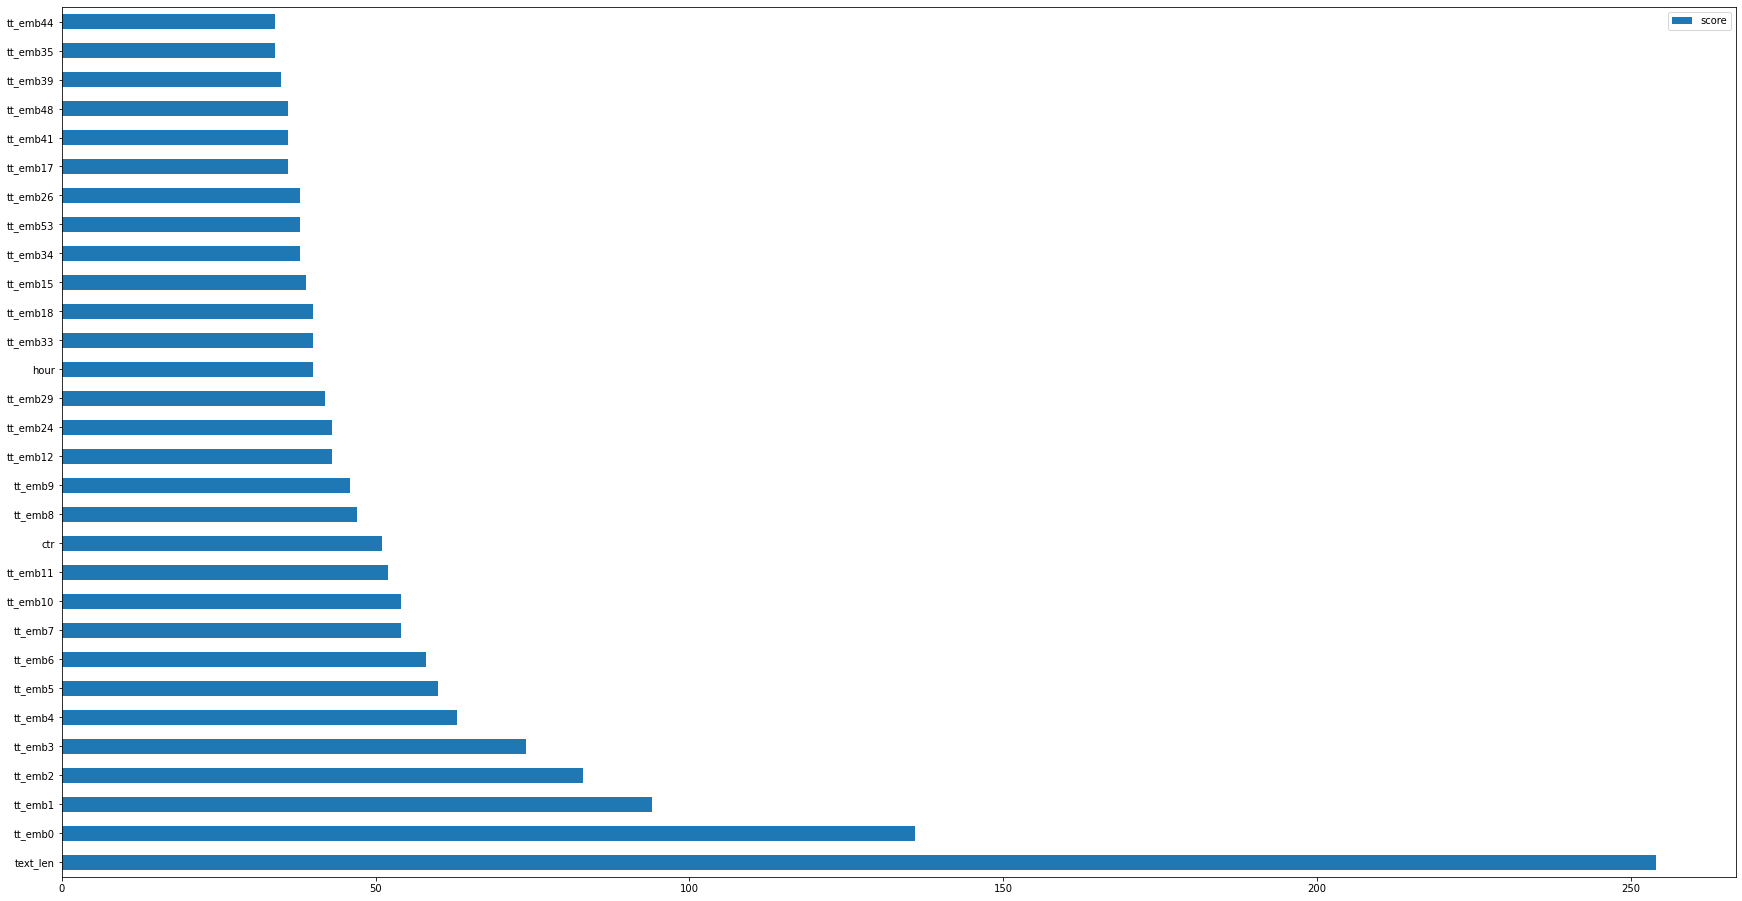

In [34]:
plot_importance(xgb_model_depth, 30, 'weight')

## full_reads_percent

In [35]:
xgb_params_fpr = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
dtrain = xgb.DMatrix(df_train[num_cols], label=df_train[['full_reads_percent']])

In [36]:
%%time
score = xgb.cv(xgb_params_fpr, dtrain, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
score.tail()

Wall time: 26.8 s


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
95,1.640427,0.039232,6.992023,0.065972,0.973826,0.001296,0.524174,0.013317
96,1.622654,0.034130,6.991911,0.066810,0.974392,0.001180,0.524188,0.013395
97,1.601045,0.027337,6.993430,0.070038,0.975073,0.000963,0.523993,0.013128
98,1.583048,0.022415,6.994763,0.071930,0.975634,0.000770,0.523808,0.013341
99,1.566225,0.014937,6.993446,0.072575,0.976152,0.000554,0.523985,0.013457


In [37]:
score[score['train-r2-mean'] == score['train-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
99,1.566225,0.014937,6.993446,0.072575,0.976152,0.000554,0.523985,0.013457


In [38]:
score[score['test-r2-mean'] == score['test-r2-mean'].max()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
15,4.712886,0.041195,6.837132,0.046951,0.784065,0.005105,0.544971,0.013879


In [39]:
#pd.DataFrame(preds_train_depth, columns = ['depth_pred'])
pred_scaler = preprocessing.StandardScaler()
tmp = pred_scaler.fit_transform(preds_train_depth.reshape(-1, 1))
pred_depth_train = pd.DataFrame(tmp, columns = ['depth_pred'])

pred_depth_val   = pd.DataFrame(pred_scaler.transform(preds_val_depth.reshape(-1, 1)), columns = ['depth_pred'])


In [40]:
xgb_model_frp = XGBRegressor(#n_estimators=1000, 
                             #max_depth=7, 
                             #eta=0.1, 
                             #subsample=0.7, 
                             #colsample_bytree=0.8,
                             n_jobs = -1,
                             random_state = XGB_RANDOMSEED,
                             )

xgb_model_frp.fit(df_train[num_cols], df_train['full_reads_percent'], #x_train[num_cols], y_train['full_reads_percent'], 
                  #early_stopping_rounds=5,
                  #eval_set=[(x_val[num_cols], y_val['full_reads_percent'])], 
                  verbose=False
                 )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, reg_lambda=1, ...)

In [41]:
# Get predictions and metrics
preds_train_frp = xgb_model_frp.predict(x_train[num_cols])
preds_val_frp   = xgb_model_frp.predict(x_val[num_cols])

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.9624049428736136, 0.961873078076462)

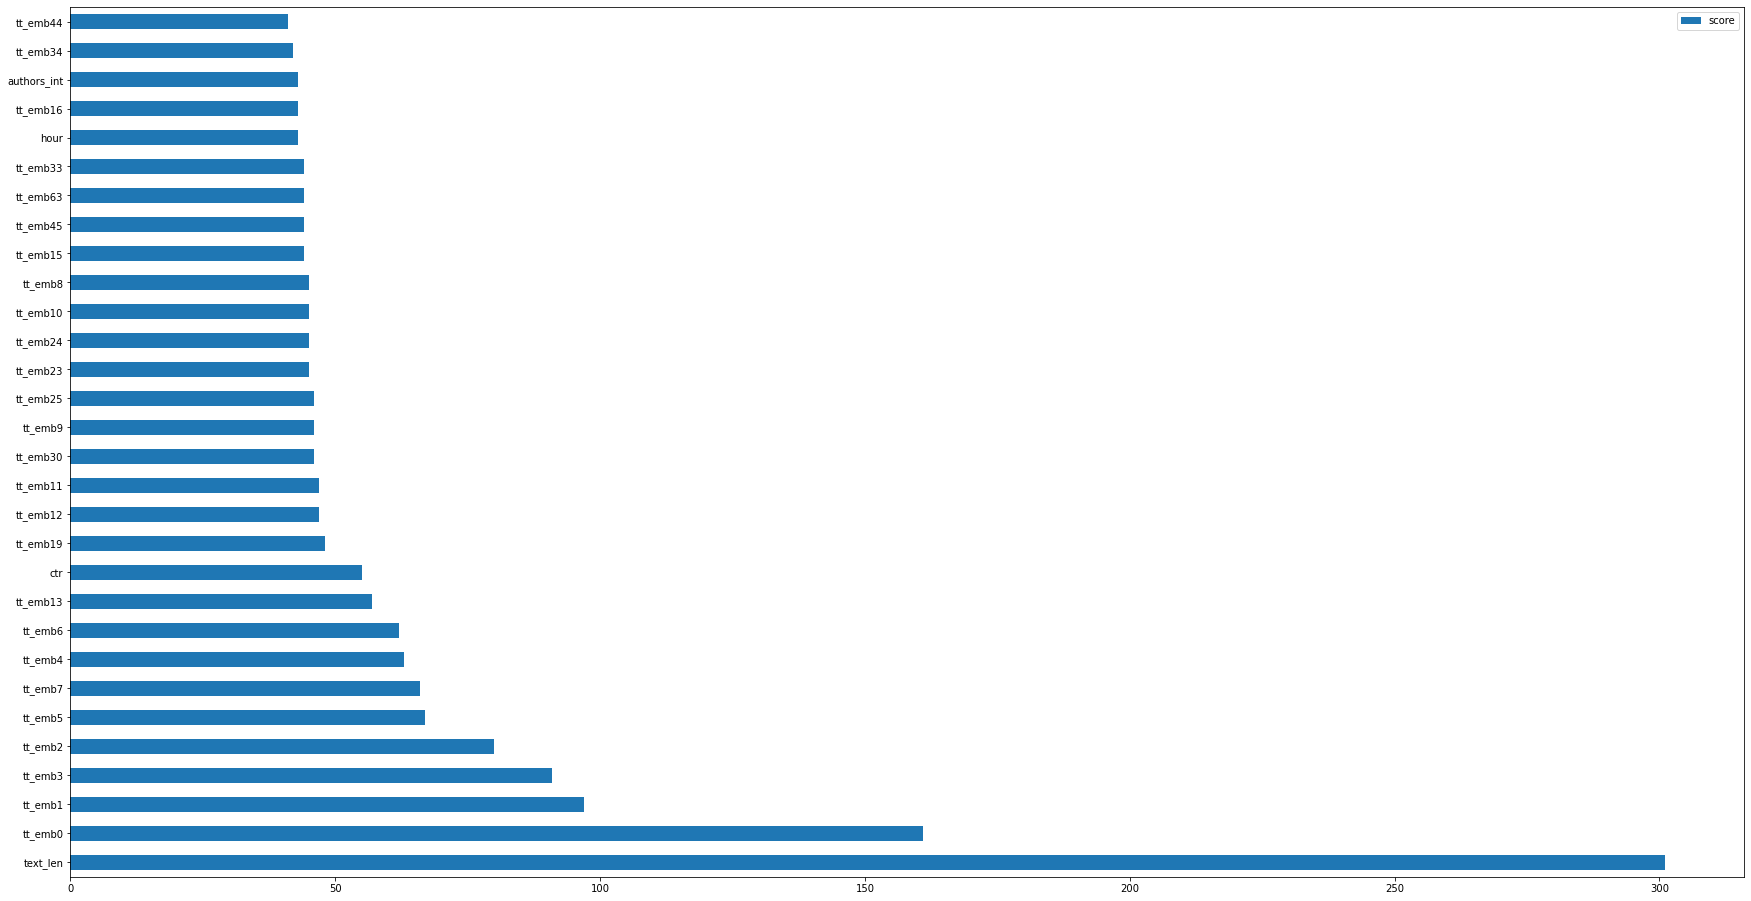

In [42]:
plot_importance(xgb_model_frp, 30, 'weight')

In [43]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val   = 0.4 * val_score_views   + 0.3 * val_score_depth   + 0.3 * val_score_frp

score_train, score_val

(0.9822171194829934, 0.9812339736389516)

# Сохраняем предсказания для ансамблей / стекинга

In [44]:
x_train_pred = x_train[['document_id']]
x_val_pred   = x_val[['document_id']]

print('before ', x_train_pred.shape, preds_train_views.shape, preds_train_depth.shape, preds_train_frp.shape)
print('before ', x_val_pred.shape,   preds_val_views.shape,   preds_val_depth.shape,   preds_val_frp.shape)

# https://github.com/pandas-dev/pandas/issues/25349
x_train_pred = pd.concat([x_train_pred.reset_index(drop=True), 
                          pd.DataFrame(preds_train_views).reset_index(drop = True), 
                          pd.DataFrame(preds_train_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_train_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)
x_val_pred   = pd.concat([x_val_pred.reset_index(drop=True),   
                          pd.DataFrame(preds_val_views).reset_index(drop = True), 
                          pd.DataFrame(preds_val_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_val_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)

x_train_pred.columns = ['document_id', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb']
x_val_pred.columns   = ['document_id', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb']

print('after ', x_train_pred.shape)
print('after ', x_val_pred.shape)

x_train_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)
x_val_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_val_part.csv'), index = False)

before  (5584, 1) (5584,) (5584,) (5584,)
before  (1397, 1) (1397,) (1397,) (1397,)
after  (5584, 4)
after  (1397, 4)


## save models

In [45]:
xgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.json'), 
                          )

xgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.json'), 
                          )

xgb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NAME}_f.json'), 
                        )

## make predict

In [46]:
pred_views = xgb_model_views.predict(df_test[num_cols])
pred_depth = xgb_model_depth.predict(df_test[num_cols])
pred_frp   = xgb_model_frp.predict(  df_test[num_cols])

In [47]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [48]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,55243.601562,1.071008,13.220510
1440,158286.093750,1.172508,25.584862
2645,177474.218750,1.193722,25.502003


In [49]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [50]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,13537.917969,1.195212,49.251446
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,6422.702148,1.061385,32.017292
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,13527.344727,1.061063,27.063379
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,6699.077637,1.057137,35.213825
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,98290.312500,1.123772,27.458132


In [51]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)